In [11]:
%%bash
curl https://sh.rustup.rs -sSf | sh -s -- -y
source $HOME/.cargo/env
rustc --version



  stable-x86_64-unknown-linux-gnu unchanged - rustc 1.88.0 (6b00bc388 2025-06-23)


Rust is installed now. Great!

To get started you may need to restart your current shell.
This would reload your PATH environment variable to include
Cargo's bin directory ($HOME/.cargo/bin).

To configure your current shell, you need to source
the corresponding env file under $HOME/.cargo.

This is usually done by running one of the following (note the leading DOT):
. "$HOME/.cargo/env"            # For sh/bash/zsh/ash/dash/pdksh
source "$HOME/.cargo/env.fish"  # For fish
source $"($nu.home-path)/.cargo/env.nu"  # For nushell
rustc 1.88.0 (6b00bc388 2025-06-23)


info: downloading installer
warn: It looks like you have an existing rustup settings file at:
warn: /root/.rustup/settings.toml
warn: Rustup will install the default toolchain as specified in the settings file,
warn: instead of the one inferred from the default host triple.
info: profile set to 'default'
info: default host triple is x86_64-unknown-linux-gnu
warn: Updating existing toolchain, profile choice will be ignored
info: syncing channel updates for 'stable-x86_64-unknown-linux-gnu'
info: default toolchain set to 'stable-x86_64-unknown-linux-gnu'


In [12]:
code = """
// Euler method with analytical comparison + plot
use std::fs::File;
use std::io::{BufWriter, Write};
use plotters::prelude::*;

// ODE function: dy/dt = cos(t) - y
fn f(t: f64, y: f64) -> f64 {
    t.cos() - y
}

// Analytical solution (exact)
fn y_exact(t: f64) -> f64 {
    0.5 * (t.cos() + t.sin()) + 0.5 * (-t).exp()
}

// Euler method implementation
fn euler(t0: f64, y0: f64, t_end: f64, n: usize) -> Vec<(f64, f64)> {
    let h = (t_end - t0) / n as f64;
    let mut result = Vec::new();
    let mut t = t0;
    let mut y = y0;

    for _ in 0..=n {
        result.push((t, y));
        y += h * f(t, y);
        t += h;
    }

    result
}

// Save CSV
fn save_to_csv(data: &[(f64, f64)], n: usize, is_exact: bool) -> std::io::Result<()> {
    let name = if is_exact {
        "analytic_solution.csv".to_string()
    } else {
        format!("euler_n{}.csv", n)
    };
    let file = File::create(name)?;
    let mut writer = BufWriter::new(file);
    writeln!(writer, "t,y")?;
    for (t, y) in data {
        writeln!(writer, "{:.4},{:.6}", t, y)?;
    }
    Ok(())
}

// Plot graph
fn plot_graph(
    d20: &[(f64, f64)],
    d100: &[(f64, f64)],
    d1000: &[(f64, f64)],
    exact: &[(f64, f64)],
) -> Result<(), Box<dyn std::error::Error>> {
    let root = BitMapBackend::new("euler_vs_analytic.png", (900, 600)).into_drawing_area();
    root.fill(&WHITE)?;

    let mut chart = ChartBuilder::on(&root)
        .caption("Euler Method vs Analytical Solution", ("sans-serif", 25))
        .margin(15)
        .x_label_area_size(40)
        .y_label_area_size(50)
        .build_cartesian_2d(0.0..5.0, -1.5..1.5)?;

    chart.configure_mesh().draw()?;

    // Plot Euler lines
    chart.draw_series(LineSeries::new(d20.to_vec(), &RED))?.label("Euler n=20").legend(|(x, y)| PathElement::new([(x, y), (x+20, y)], &RED));
    chart.draw_series(LineSeries::new(d100.to_vec(), &BLUE))?.label("Euler n=100").legend(|(x, y)| PathElement::new([(x, y), (x+20, y)], &BLUE));
    chart.draw_series(LineSeries::new(d1000.to_vec(), &GREEN))?.label("Euler n=1000").legend(|(x, y)| PathElement::new([(x, y), (x+20, y)], &GREEN));

    // Plot exact solution
    chart.draw_series(LineSeries::new(exact.to_vec(), &BLACK))?.label("Analytical").legend(|(x, y)| PathElement::new([(x, y), (x+20, y)], &BLACK));

    chart.configure_series_labels().background_style(&WHITE.mix(0.8)).draw()?;

    println!("✅ Plot saved as euler_vs_analytic.png");
    Ok(())
}

fn main() -> Result<(), Box<dyn std::error::Error>> {
    // Step sizes
    let d20 = euler(0.0, 1.0, 5.0, 20);
    let d100 = euler(0.0, 1.0, 5.0, 100);
    let d1000 = euler(0.0, 1.0, 5.0, 1000);

    // Exact curve
    let exact: Vec<(f64, f64)> = (0..=1000)
        .map(|i| {
            let t = i as f64 * 5.0 / 1000.0;
            (t, y_exact(t))
        })
        .collect();

    // Save all CSVs
    save_to_csv(&d20, 20, false)?;
    save_to_csv(&d100, 100, false)?;
    save_to_csv(&d1000, 1000, false)?;
    save_to_csv(&exact, 0, true)?;

    // Plot all 4 lines
    plot_graph(&d20, &d100, &d1000, &exact)?;

    Ok(())
}
"""

with open("main.rs", "w") as f:
    f.write(code)


In [13]:
%%writefile Cargo.toml
[package]
name = "euler_plot"
version = "0.1.0"
edition = "2021"

[dependencies]
plotters = "0.3"


Overwriting Cargo.toml


In [14]:
%%bash
source $HOME/.cargo/env
mkdir -p src
mv main.rs src/
cargo run --release


✅ Plot saved as euler_vs_analytic.png


   Compiling euler_plot v0.1.0 (/content)
    Finished `release` profile [optimized] target(s) in 4.39s
     Running `target/release/euler_plot`


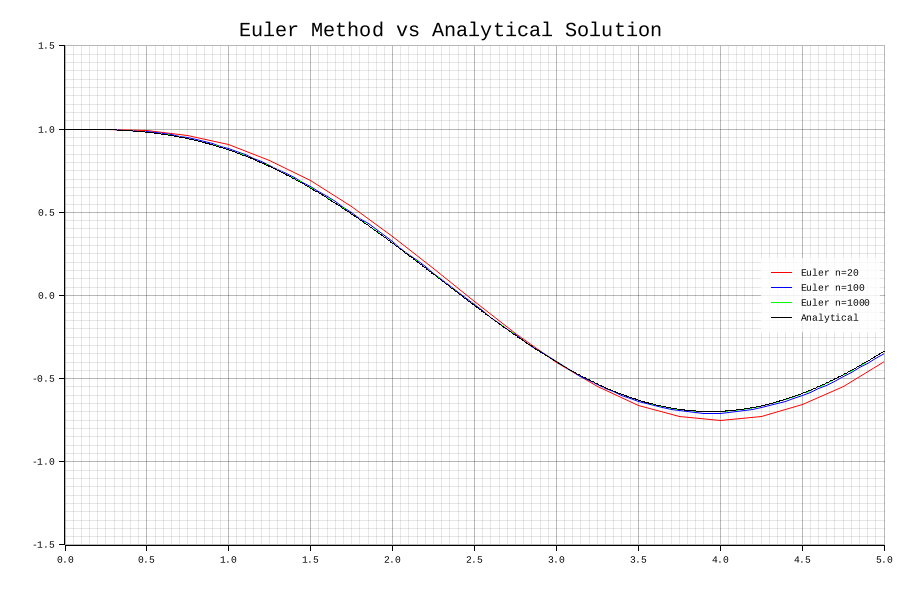

In [15]:
from PIL import Image
Image.open("euler_vs_analytic.png")
